In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import hub
from script import vggish_input, vggish_params
import os

In [2]:
binary_weight = '/scratch/bs4283/auditory_data/data_20sample/binary_weight3.pt'
binary_bias = '/scratch/bs4283/auditory_data/data_20sample/binary_bias3.pt'
tunning_value_folder = '/scratch/bs4283/auditory_data/data_20sample/tunnning_value/new_tunning_value/normalize/'

In [3]:
device = torch.device('cuda')

In [4]:
def list_sort_tunning(x : str):
    if '.' in x:
        # 将文件名字用_进行分割
        x = x.rpartition('.')
        # 将x用.进行分割，最后拿到数字
        x = x[0][-1]
    else:
        x = 0
    return int(x)

In [5]:
attnmats=[]
fileList = os.listdir('/scratch/bs4283/auditory_data/data_20sample/tunnning_value/new_tunning_value/normalize')
ss_path = '/scratch/bs4283/auditory_data/data_20sample/tunnning_value/new_tunning_value/normalize'
fileList.sort(key=list_sort_tunning)



In [ ]:
filename = fileList[0]
filepath = os.path.join(ss_path,filename)
value = torch.load(filepath)

In [7]:
import matplotlib.pyplot as plt

In [ ]:
value.cpu().numpy().shape

In [6]:
v_qul = []
for layer in range(6):
    filename = fileList[layer]
    filepath = os.path.join(ss_path,filename)
    value = torch.load(filepath)
    value = value.cpu().detach().numpy()
    max_v = np.amax(np.abs(value),axis=0)
    v_qul.append(max_v)

In [ ]:
v_qul

{'whiskers': [<matplotlib.lines.Line2D at 0x1463e8325610>,
 'caps': [<matplotlib.lines.Line2D at 0x1463e8325b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1463e8311250>,
 'medians': [<matplotlib.lines.Line2D at 0x1463e83420d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1463e8342370>,
 'means': []}

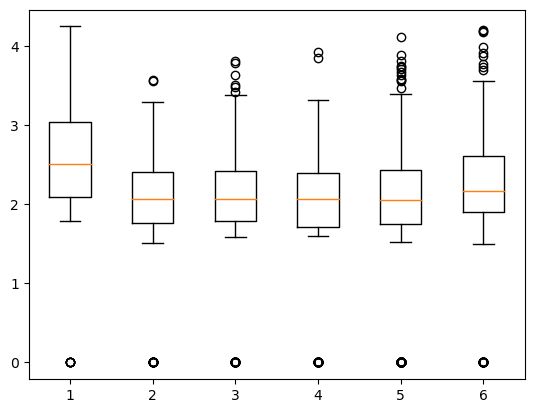

In [8]:
plt.boxplot(v_qul)

In [ ]:
def make_amats(speaker,layer,sevec):
    attnmats=[]
    fileList = os.listdir('/scratch/bs4283/auditory_data/data_20sample/tunnning_value')
    ss_path = '/scratch/bs4283/auditory_data/data_20sample/tunnning_value'
    fileList.sort(key=list_sort_tunning)
    filename = fileList[layer]
    filepath = os.path.join(ss_path,filename)
    value = torch.load(filepath)
    
    for ii in range(6):
        if ii == layer : 
            k=value[speaker,:]/(torch.max(torch.abs(value),0).values)
            k=torch.unsqueeze(torch.unsqueeze(k,1),1)
            k[k == torch.inf] = 0 
            k[k == -torch.inf] = 0 
            k = torch.from_numpy(np.nan_to_num(k.cpu().numpy())).to(device)
            
            if ii == 0:
                amat = torch.ones([64, 96, 64]).to(device) + torch.tile(k,[1,96,64]).to(device) *sevec
                attnmats.append(amat)
            elif ii == 1:
                amat = torch.ones([128, 48, 32]).to(device)  + torch.tile(k,[1,48,32]).to(device) *sevec
                attnmats.append(amat)
            elif ii == 2:
                amat = torch.ones([256, 24, 16]).to(device)  + torch.tile(k,[1,24,16]).to(device) *sevec
                attnmats.append(amat)
            elif ii == 3:
                amat = torch.ones([256, 24, 16]).to(device)  + torch.tile(k,[1,24,16]).to(device) *sevec
                attnmats.append(amat)
            elif ii == 4:
                amat = torch.ones([512, 12, 8]).to(device)  + torch.tile(k,[1,12,8]).to(device) *sevec
                attnmats.append(amat)
            elif ii == 5:
                amat = torch.ones([512, 12, 8]).to(device)  + torch.tile(k,[1,12,8]).to(device) *sevec
                attnmats.append(amat)
            
            
        else:
            if ii == 0:
                amat = torch.ones([64, 96, 64]).to(device) 
                attnmats.append(amat)
            elif ii == 1:
                amat = torch.ones([128, 48, 32]).to(device) 
                attnmats.append(amat)
            elif ii == 2:
                amat = torch.ones([256, 24, 16]).to(device) 
                attnmats.append(amat)
            elif ii == 3:
                amat = torch.ones([256, 24, 16]).to(device) 
                attnmats.append(amat)
            elif ii == 4:
                amat = torch.ones([512, 12, 8]).to(device) 
                attnmats.append(amat)
            elif ii == 5:
                amat = torch.ones([512, 12, 8]).to(device) 
                attnmats.append(amat)
    return attnmats

In [ ]:
class VGG16ish(nn.Module):
    def __init__(self,binary_weight,binary_bias,tunning):
        super(VGG16ish, self).__init__()
        import torch
        import torch.nn as nn
        self.tunning = tunning
        self.binary_weight = binary_weight.to(device)
        self.binary_bias = binary_bias.to(device)
        base_model = torch.hub.load('harritaylor/torchvggish', 'vggish')
        model_list = list(base_model.children())
        self.model_layer0 = model_list[0][0:2]
        self.model_layer1 = model_list[0][2:5]
        self.model_layer2 = model_list[0][5:8]
        self.model_layer3 = model_list[0][8:10]
        self.model_layer4 = model_list[0][10:13]
        self.model_layer5 = model_list[0][13:15]
        self.model_layer6 = model_list[0][15] 
        self.linear1 = model_list[1]
        self.linear2 = nn.Linear(128,1)
        self.linear2.weight = nn.Parameter(self.binary_weight)
        self.linear2.bias = nn.Parameter(self.binary_bias)
        self.sigmoid = nn.Sigmoid()
        
        
        
    def forward(self, x):
        out = self.model_layer0(x)
        out = torch.mul(out,self.tunning[0])
        out = self.model_layer1(out)
        out = torch.mul(out,self.tunning[1])
        out = self.model_layer2(out)
        out = torch.mul(out,self.tunning[2])
        out = self.model_layer3(out)
        out = torch.mul(out,self.tunning[3])
        out = self.model_layer4(out)
        out = torch.mul(out,self.tunning[4])
        out = self.model_layer5(out)
        out = torch.mul(out,self.tunning[5])
        out = self.model_layer6(out)
        out = torch.transpose(out, 1, 3)
        out = torch.transpose(out, 1, 2)
        out = out.contiguous().view(x.size(0), -1)
        
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        
        
        return out

Prepare data

In [ ]:
from script import vggish_input

In [ ]:
def list_sort_data(x : str):
    if '.' in x:
        # 将文件名字用_进行分割
        x = x.rpartition('.')
        # 将x用.进行分割，最后拿到数字
        if x[0][1] == '-':      
            x = x[0][0]
        else:
            x=x[0][0:2]
    else:
        x = 0
    return int(x)

In [ ]:
# cat = 2
#layer = 5 
astrgs=np.arange(0,1.,.5)
data_num = 75
data_folder = '/scratch/bs4283/auditory_data/data_20sample/test_voice_20'


In [ ]:
cat = 0
fileList_data = os.listdir('/scratch/bs4283/auditory_data/data_20sample/combine_test_20')
fileList_data.sort(key=list_sort_data)
sub = torch.arange(9000)
sub = sub.numpy()
sub_cat = torch.arange(cat*150,(cat+1)*150,1)
sub_cat = sub_cat.numpy()
sub_diff = np.setdiff1d(sub,sub_cat)
r1 = torch.randperm(150)
r2 = torch.randperm(8850)
data_poi = np.array(fileList_data)[sub_cat[r1.numpy()]]
data_neg = np.array(fileList_data)[sub_diff[r2.numpy()]]
poi_data = torch.tensor([]).to(device)
neg_data = torch.tensor([]).to(device)

In [ ]:
for kk in range(data_num):
    poi_path = os.path.join(data_folder,data_poi[kk])
    p = vggish_input.wavfile_to_examples(poi_path).to(device)
    poi_data = torch.cat([poi_data,p])


orde = -1
while neg_data.size(dim=0) < 75:
    orde = orde + 1 
    filename = data_neg[orde].rpartition('.')
    if int(filename[0][3:5]) == cat+1:
           continue
    neg_path = os.path.join(data_folder,data_neg[orde])
    n = vggish_input.wavfile_to_examples(neg_path).to(device)
    neg_data = torch.cat([neg_data,n])

In [ ]:
w = torch.load(binary_weight)
bin_b = torch.load(binary_bias)[cat]
bin_w = w[cat,:]
bin_w = torch.unsqueeze(bin_w,0)

In [ ]:
pr = np.ones([2,6])
nr = np.ones([2,6])
for jj in range(6):
    at = -1
    for ast in astrgs:
        at = at+1
        t = make_amats(cat,jj,ast)
        model_v = VGG16ish(binary_weight = bin_w,binary_bias = bin_b ,tunning = t)            
        model_v.eval()
        p_result = model_v(poi_data)
        n_result  = model_v(neg_data)
        p_rate = torch.sum(p_result>0.5).cpu().numpy()/75
        n_rate = torch.sum(n_result<0.5).cpu().numpy()/75
        pr[at,jj] = p_rate
        nr[at,jj] = n_rate

In [ ]:
str(sub_list[0].numpy())

In [ ]:
sub_list = torch.tensor([1,2,3,4,5,6,8,10,11,12,13,28,36,43,47,52,56,57,58,59])-1
cat_s = -1 
for cat in sub_list:
    cat_s = cat_s + 1 
    fileList_data = os.listdir('/scratch/bs4283/auditory_data/data_20sample/combine_test_20')
    fileList_data.sort(key=list_sort_data)
    sub = torch.arange(3000)
    sub = sub.numpy()
    sub_cat = torch.arange(cat_s*150,(cat_s+1)*150,1)
    sub_cat = sub_cat.numpy()
    sub_diff = np.setdiff1d(sub,sub_cat)
    r1 = torch.randperm(150)
    r2 = torch.randperm(2850)
    data_poi = np.array(fileList_data)[sub_cat[r1.numpy()]]
    data_neg = np.array(fileList_data)[sub_diff[r2.numpy()]]
    poi_data = torch.tensor([]).to(device)
    neg_data = torch.tensor([]).to(device)
    
    for kk in range(data_num):
        poi_path = os.path.join(data_folder,data_poi[kk])
        p = vggish_input.wavfile_to_examples(poi_path).to(device)
        poi_data = torch.cat([poi_data,p])


    orde = -1
    while neg_data.size(dim=0) < 75:
        orde = orde + 1 
        filename = data_neg[orde].rpartition('.')
        if int(filename[0][3:5]) == cat+1:
               continue
        neg_path = os.path.join(data_folder,data_neg[orde])
        n = vggish_input.wavfile_to_examples(neg_path).to(device)
        neg_data = torch.cat([neg_data,n])
        
        
    w = torch.load(binary_weight)
    bin_b = torch.load(binary_bias)[cat_s]
    bin_w = w[cat_s,:]
    bin_w = torch.unsqueeze(bin_w,0)
    
    pr = np.ones([2,6])
    nr = np.ones([2,6])
    for jj in range(6):
        at = -1
        for ast in astrgs:
            at = at+1
            t = make_amats(cat_s,jj,ast)
            model_v = VGG16ish(binary_weight = bin_w,binary_bias = bin_b ,tunning = t)            
            model_v.eval()
            p_result = model_v(poi_data)
            n_result  = model_v(neg_data)
            p_rate = torch.sum(p_result>0.5).cpu().numpy()/75
            n_rate = torch.sum(n_result<0.5).cpu().numpy()/75
            pr[at,jj] = p_rate
            nr[at,jj] = n_rate
    np.save('/scratch/bs4283/auditory_data/data_20sample/result2/cat'+ str(cat.numpy()) + '_poi.npy',pr)
    np.save('/scratch/bs4283/auditory_data/data_20sample/result2/cat'+ str(cat.numpy()) + '_neg.npy',nr)            

Prepare data for raw test data

In [ ]:
def list_sort_data(x : str):
    if '.' in x:

        x = x.rpartition('.')

        if x[0][1] == '-':      
            x = x[0][0]
        else:
            x=x[0][2:4]
    else:
        x = 0
    return int(x)

In [ ]:
sub_list = torch.tensor([1,2,3,4,5,6,8,10,11,12,13,28,36,43,47,52,56,57,58,59])-1
cat_s = -1 
for cat in sub_list:
    cat_s = cat_s + 1 
    fileList_data = os.listdir('/scratch/bs4283/auditory_data/data_20sample/test_voice_20')
    fileList_data.sort(key=list_sort_data)
    sub = torch.arange(3000)
    sub = sub.numpy()
    sub_cat = torch.arange(cat_s*150,(cat_s+1)*150,1)
    sub_cat = sub_cat.numpy()
    sub_diff = np.setdiff1d(sub,sub_cat)
    r1 = torch.randperm(150)
    r2 = torch.randperm(2850)
    data_poi = np.array(fileList_data)[sub_cat[r1.numpy()]]
    data_neg = np.array(fileList_data)[sub_diff[r2.numpy()]]
    poi_data = torch.tensor([]).to(device)
    neg_data = torch.tensor([]).to(device)
    
    for kk in range(data_num):
        poi_path = os.path.join(data_folder,data_poi[kk])
        p = vggish_input.wavfile_to_examples(poi_path).to(device)
        poi_data = torch.cat([poi_data,p])


    orde = -1
    while neg_data.size(dim=0) < 75:
        orde = orde + 1 
        filename = data_neg[orde].rpartition('.')
 #       if int(filename[0][3:5]) == cat+1:
 #             continue
        neg_path = os.path.join(data_folder,data_neg[orde])
        n = vggish_input.wavfile_to_examples(neg_path).to(device)
        neg_data = torch.cat([neg_data,n])
        
        
    w = torch.load(binary_weight)
    bin_b = torch.load(binary_bias)[cat_s]
    bin_w = w[cat_s,:]
    bin_w = torch.unsqueeze(bin_w,0)
    
    pr = np.ones([2,6])
    nr = np.ones([2,6])
    for jj in range(6):
        at = -1
        for ast in astrgs:
            at = at+1
            t = make_amats(cat_s,jj,ast)
            model_v = VGG16ish(binary_weight = bin_w,binary_bias = bin_b ,tunning = t)            
            model_v.eval()
            p_result = model_v(poi_data)
            n_result  = model_v(neg_data)
            p_rate = torch.sum(p_result>0.5).cpu().numpy()/75
            n_rate = torch.sum(n_result<0.5).cpu().numpy()/75
            pr[at,jj] = p_rate
            nr[at,jj] = n_rate
    np.save('/scratch/bs4283/auditory_data/data_20sample/result_raw_data/cat'+ str(cat.numpy()) + '_poi.npy',pr)
    np.save('/scratch/bs4283/auditory_data/data_20sample/result_raw_data/cat'+ str(cat.numpy()) + '_neg.npy',nr)            